In [14]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import reduce
% matplotlib inline
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
##Import all datasets
gold_prices_df = pd.read_pickle('/Users/yajasdwivedi/metis/LinearRegressionPriceGold/gold_prices_df.pkl')
crb_df = pd.read_pickle('/Users/yajasdwivedi/metis/LinearRegressionPriceGold/crb_df.pkl')
inflation_rate_df_final = pd.read_pickle('/Users/yajasdwivedi/metis/LinearRegressionPriceGold/inflation_rate_df_final.pkl')
m1_df_final = pd.read_pickle('/Users/yajasdwivedi/metis/LinearRegressionPriceGold/m1_df_final.pkl')
eurusd_df = pd.read_pickle('/Users/yajasdwivedi/metis/LinearRegressionPriceGold/eurusd_df.pkl')

In [3]:
##Convert all DATEs to datetime objects
gold_prices_df.DATE = pd.to_datetime(gold_prices_df.DATE)
crb_df.DATE = pd.to_datetime(crb_df.DATE)
inflation_rate_df_final.DATE = pd.to_datetime(inflation_rate_df_final.DATE)
m1_df_final.DATE = pd.to_datetime(m1_df_final.DATE)
eurusd_df.DATE = pd.to_datetime(eurusd_df.DATE)

In [4]:
##Combine all Dataframes into one
dfs = [gold_prices_df, crb_df, inflation_rate_df_final, m1_df_final, eurusd_df]
df_final = reduce(lambda left,right: pd.merge(left,right,on='DATE'), dfs)

In [5]:
df_final.head()

,DATE,Gold_Price,CRB_Price,inflation_rate_percent,M1SL,EURUSD
0,2016-08-01,1349.65,178.21,1.06,3317.7,1.1162
1,2016-08-02,1363.75,177.32,1.06,3317.7,1.1227
2,2016-08-03,1358.90,179.79,1.06,3317.7,1.1149
3,2016-08-04,1257.70,181.35,1.06,3317.7,1.1130
4,2016-08-04,1362.75,181.35,1.06,3317.7,1.1130


In [6]:
df_final.corr()

,Gold_Price,CRB_Price,inflation_rate_percent,M1SL,EURUSD
Gold_Price,1.000000,0.057360,-0.284120,0.386749,0.713998
CRB_Price,0.057360,1.000000,0.488863,0.138726,0.150364
inflation_rate_percent,-0.284120,0.488863,1.000000,0.388295,0.030426
M1SL,0.386749,0.138726,0.388295,1.000000,0.841984
EURUSD,0.713998,0.150364,0.030426,0.841984,1.000000


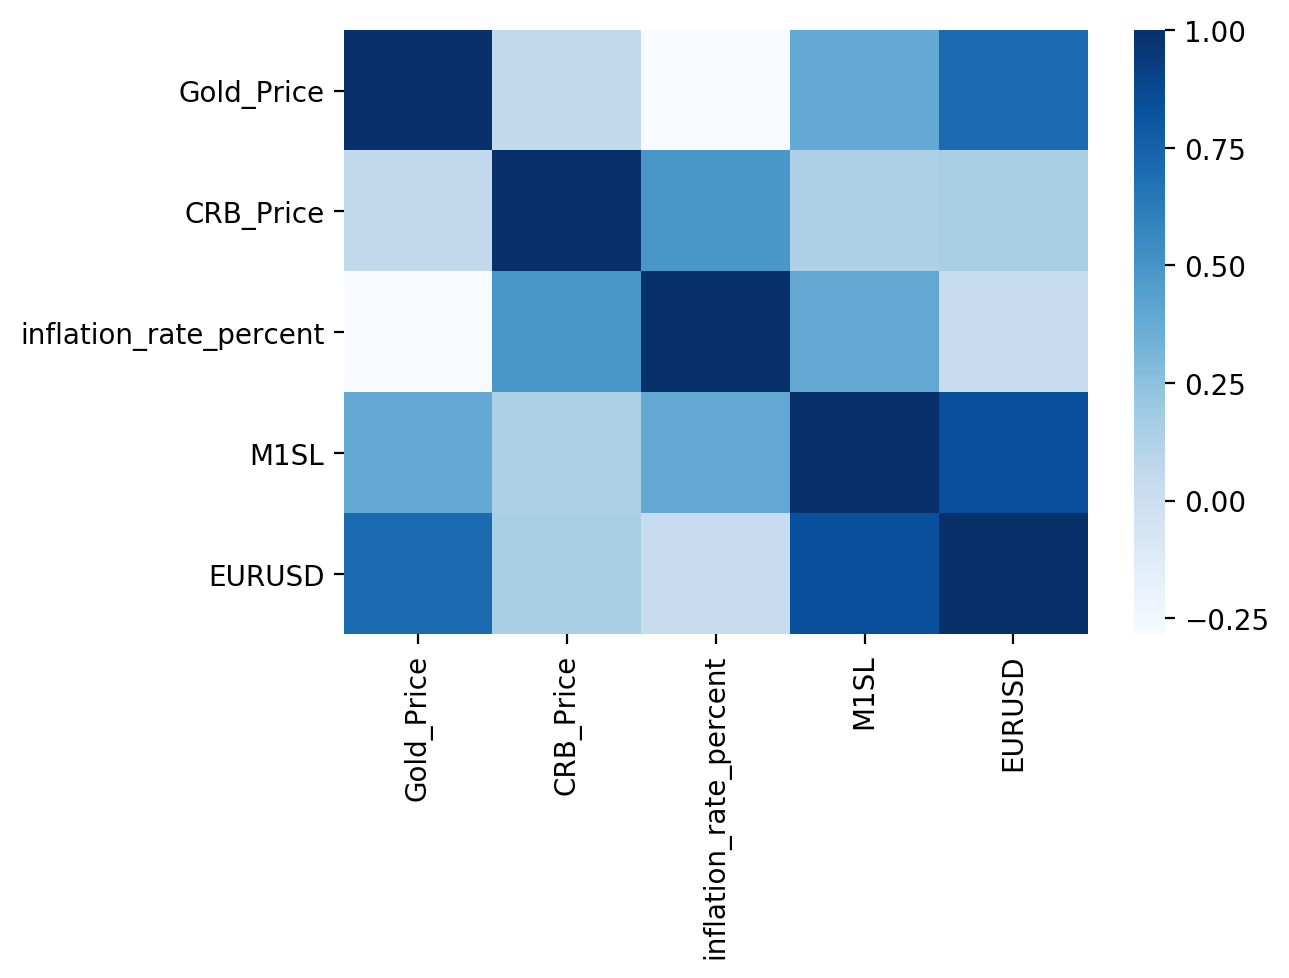

In [9]:
plt.figure(dpi=200)
sns.heatmap(df_final.corr(), cmap=plt.cm.Blues)

In [10]:
##Split dataframe into dependent and independent variables
X = df_final[[x for x in df_final.columns if x!='Gold_Price' and x!='DATE']]
y = df_final['Gold_Price']

In [11]:
ssX = StandardScaler()
#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#Scale training data
X_train_scaled = ssX.fit_transform(X_train) #Scaled and calculating parameters for 'z-score'
X_test_scaled = ssX.transform(X_test)

In [12]:
#Function to report Mean Absolute Error(MAE)
def report_abs_score(model,input_t,output_t):
    predictions = model.predict(input_t)
    return np.mean(-abs(predictions - output_t))

In [25]:
## First Linear Model - OLS
lr1 = LinearRegression()
lr1.fit(X_train_scaled, y_train)
#Return R^2 score
print("R^2 score: {}".format(lr1.score(X_train_scaled, y_train)))
#Return training MAE
print("Training MAE: {}".format(report_abs_score(lr1,X_train_scaled,y_train)))
#Return test MAE
print("Test MAE: {}".format(report_abs_score(lr1,X_test_scaled,y_test)))
#Cross-Validation R^2 scores
print("5 fold CV scores: {}". format(cross_val_score(lr1, X_train_scaled, y_train, cv=5,scoring=None)))
#Cross-Validation MAE scores
print("The mean MAE for train data across 5 fold CV is: " + str(np.mean(cross_val_score(lr1, X_train_scaled, y_train,cv =5, scoring='neg_mean_absolute_error'))))

R^2 score: 0.6612818225171535
Training MAE: -22.480026756597777
Test MAE: -25.401234198883053
5 fold CV scores: [0.70202117 0.70910969 0.5384111  0.65826696 0.60534095]
The mean MAE for train data across 5 fold CV is: -22.877895333270963


Text(0.5,1,'Residual Chart - OLS')

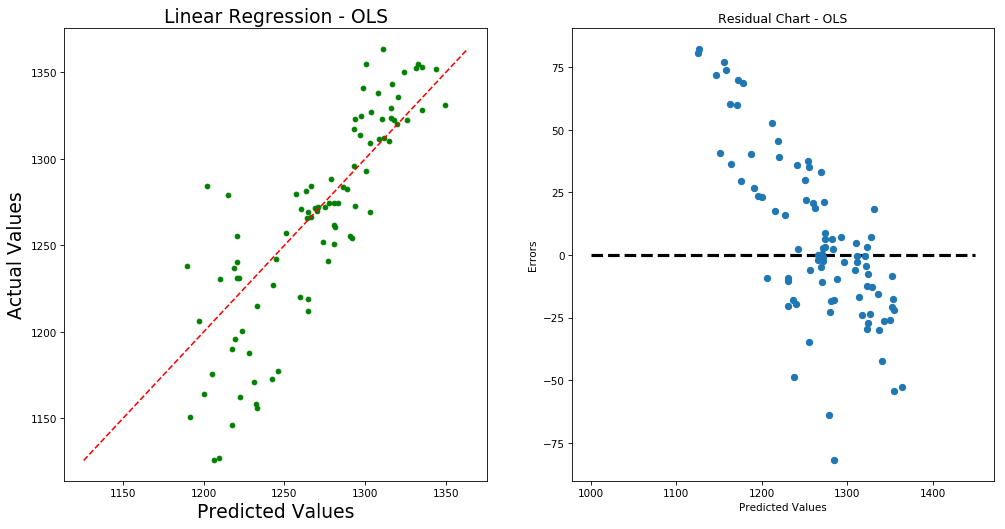

In [33]:
plt.figure(dpi=75, figsize=(16,8))
###
plt.subplot(1,2,1)
plt.scatter(lr1.predict(X_test_scaled), y_test, s= 20, marker = 'o', c='green') 
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],'r--')
plt.xlabel("Predicted Values", fontsize = 18)
plt.ylabel("Actual Values", fontsize = 18)
plt.title("Linear Regression - OLS", fontsize = 18)
###
plt.subplot(1,2,2)
predictions_lr1 = lr1.predict(X_test_scaled)
errors_lr1 = predictions_lr1 - y_test
plt.plot(y_test,errors_lr1, 'o')
plt.hlines(y=0, xmin=1000, xmax=1450, colors='k', linestyles='--', lw=3)
plt.xlabel("Predicted Values")
plt.ylabel("Errors")
plt.title("Residual Chart - OLS")

In [31]:
## Second Model - w/ Polynomial Features
poly = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly.fit(X_train_scaled,y_train)
#Return R^2 score
print("R^2 score: {}".format(poly.score(X_train_scaled, y_train)))
#Return training MAE
print("Training MAE: {}".format(report_abs_score(poly,X_train_scaled,y_train)))
#Return test MAE
print("Test MAE: {}".format(report_abs_score(poly,X_test_scaled,y_test)))
#Cross-Validation R^2 scores
print("5 fold CV scores: {}". format(cross_val_score(poly, X_train_scaled, y_train, cv=5,scoring=None)))
#Cross-Validation MAE scores
print("The mean MAE for train data across 5 fold CV is: " + str(np.mean(cross_val_score(poly, X_train_scaled, y_train,cv =5, scoring='neg_mean_absolute_error'))))

R^2 score: 0.8618629611124229
Training MAE: -14.898344942955127
Test MAE: -14.744951262115972
5 fold CV scores: [0.84123083 0.88691048 0.74363259 0.86839147 0.86090487]
The mean MAE for train data across 5 fold CV is: -15.687434110599517


Text(0.5,1,'Residual Chart - Polynomial Features')

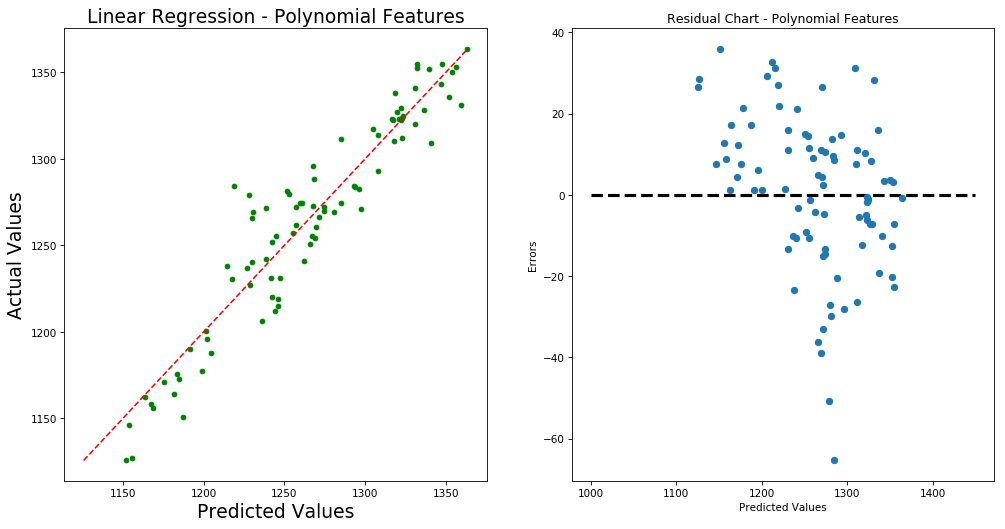

In [32]:
plt.figure(dpi=75, figsize=(16,8))
###
plt.subplot(1,2,1)
plt.scatter(poly.predict(X_test_scaled), y_test, s= 20, marker = 'o', c='green') 
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],'r--')
plt.xlabel("Predicted Values", fontsize = 18)
plt.ylabel("Actual Values", fontsize = 18)
plt.title("Linear Regression - Polynomial Features", fontsize = 18)
###
plt.subplot(1,2,2)
predictions_poly = poly.predict(X_test_scaled)
errors_poly = predictions_poly - y_test
plt.plot(y_test,errors_poly, 'o')
plt.hlines(y=0, xmin=1000, xmax=1450, colors='k', linestyles='--', lw=3)
plt.xlabel("Predicted Values")
plt.ylabel("Errors")
plt.title("Residual Chart - Polynomial Features")